In [2]:
import scipy
import pylab
import numpy as np
import matplotlib
import matplotlib.patches as patches
import astroquery
from astroquery.splatalogue import Splatalogue,utils
from astropy import units as u
from astropy.table import vstack, Table

%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='sans-serif')
matplotlib.rcParams.update({'font.size':9})

### Define some functions

In [3]:
def atmosphere(file):
    #read in a file of atmospheric transmission vs. frequency
    inp1 = file
    input1 = open(inp1,'r')
    newline1 = input1.readlines()
    input1.close()
    fghz = pylab.zeros(np.size(newline1))
    trans = pylab.zeros(np.size(newline1))
    for num,line in enumerate(newline1):
        splitline = str.split(line)
        fghz[num]   = float(splitline[0]) 
        trans[num]  = float(splitline[1])
    return fghz, trans


def trimmed_query(*args,**kwargs):
    # Define the Splatalogue parameters you want returned
    columns = ('Species','Resolved QNs','Freq-GHz(rest frame,redshifted)',
                    'Meas Freq-GHz(rest frame,redshifted)',
                    'Log<sub>10</sub> (A<sub>ij</sub>)',
                    'E_U (K)')
    table = S.query_lines(*args, **kwargs)[columns]
    # Rename columns to shorten them or remove weird formatting
    table.rename_column('Log<sub>10</sub> (A<sub>ij</sub>)','log10(Aij)')
    table.rename_column('E_U (K)','EU_K')
    table.rename_column('Resolved QNs','QNs')
    table.rename_column('Freq-GHz(rest frame,redshifted)','Freq-GHz')
    table.rename_column('Meas Freq-GHz(rest frame,redshifted)','Meas Freq-GHz')
    return table

def splat(bbs,bws,printit=1,*args,**kwargs):
    # Print out a table of molecule transitions lying in a specified spectral setup
    # Inputs: Array of central frequencies and SPW bandwidths (specified in GHz)
    # Outputs: Table of lines in all subbands
    for i,bb in enumerate(bbs):
        low,hi = bb-bws[i]/2.0, bb+bws[i]/2.0
        table = trimmed_query(low*u.GHz, hi*u.GHz)
        if printit == 1:
            print('')
            print('****************************************')
            print('Sub-Band %i  %3.2f - %3.2f GHz'%(i,low,hi))
            print('****************************************')
            print( table)
        if i == 0:
            table_save = table
        if i > 0:
            table_save = vstack([table_save,table])

        
    # Get arrays of frequency, chemical formula for plotting 
    # observed transitions in each setup
    freqs = np.maximum(pylab.array(table_save['Freq-GHz']),
                         pylab.array(table_save['Meas Freq-GHz']))
    mols = np.array([specy.replace('vt=0','').replace('v=0','').replace('3&Sigma;','').replace('&alpha;','alpha').replace('t-','')  
                        for specy in table_save['Species'].data])
    return freqs, mols

def whichmol(specy):
    # IJMC, 2017/04/09, 18:36 <--- co-author credit!
    color = -1
    for ii, this_mol in enumerate(allmol):
        stripped_list = [mol.strip() for mol in this_mol]
        if specy in stripped_list:
            color = ii
    return color

def SPW_plot(LO,bbs,bws,ms,fs,ls,pc,lb,atm):
    # Plot lines in the lower sideband
    fig1 = pylab.figure(1,figsize=(12,5))
    ax = fig1.add_subplot(111)
    if atm == 1:
        fghz,trans = atmosphere('atmosphereplot.data')
        pylab.plot(fghz,trans,color='k')
    for i,c in enumerate(pc):
        pylab.vlines(0,0,1, color=c,linestyle=ls[i], label=lb[i])
    pylab.xlim([LO-8.0,LO-4.0])
    pylab.ylim([0,1])
    ax.text(0.01,0.9, "LSB", fontsize=30,transform=ax.transAxes)
    pylab.xlabel('Frequency (GHz)', fontsize=20)
    pylab.ylabel('Atmospheric Transmissivity', fontsize=15)
    for j, bb in enumerate(bbs):
        if (bb < LO-4.0)*(bb>LO-8.0):
            ax.add_patch(patches.Rectangle((bb-bws[j]/2.0,0), bws[j], 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))
  
    for i,f in enumerate(fs):
        if (f< LO-4.0)*(f>LO-8.0):
            if ms[i] != ms[i-1]: # A very crude hack for removing HFS 
                if ms[i].strip() !='HCO': # I cannot for the life of me keep splatalogue from including HCO
                    pylab.vlines(f,0,1, linestyle=ls[whichmol(ms[i])],colors=pc[whichmol(ms[i])])
                    p_i = 1-(i%10)/10.0 - 0.05
                    pylab.text(f+0.02,p_i,ms[i],fontsize=14,color=pc[whichmol(ms[i])])
    leg = pylab.legend(loc=4, fontsize=15)
    for color,text in zip(pc,leg.get_texts()):
        text.set_color(color)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if atm ==0:
        ax.get_yaxis().set_visible(False) # can change this if you want to plot atmosphere data on y-axis

    # plot lines in the upper sideband
    fig2 = pylab.figure(2,figsize=(12,5))
    ax = fig2.add_subplot(111)
    if atm ==1:
        fghz,trans = atmosphere('atmosphereplot.data')
        pylab.plot(fghz,trans,color='k')
    for i,c in enumerate(pc):
        pylab.vlines(0,0,1, color=c,linestyle=ls[i], label=lb[i])
    pylab.xlim([LO+4.0,LO+8.0])
    pylab.ylim([0,1])
    ax.text(0.01,0.9, "USB", fontsize=30,transform=ax.transAxes)
    pylab.xlabel('Frequency (GHz)', fontsize=20)
    pylab.ylabel('Atmospheric Transmissivity', fontsize=15)
    for j, bb in enumerate(bbs):
        if (bb< LO+8.0)*(bb>LO+4.0):
            ax.add_patch(patches.Rectangle((bb-bws[j]/2.0,0), bws[j], 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))

    for i,f in enumerate(fs):
        if (f< LO+8.0)*(f>LO+4.0):
            if ms[i] != ms[i-1]:
                pylab.vlines(f,0,1, colors=pc[whichmol(ms[i])])
                p_i = 1-(i%10)/10.0 - 0.05
                pylab.text(f+0.02,p_i,ms[i],fontsize=14,color=pc[whichmol(ms[i])])
    leg = pylab.legend(loc=3,fontsize=15)
    for color,text in zip(pc,leg.get_texts()):
        text.set_color(color)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if atm ==0:
        ax.get_yaxis().set_visible(False)
    return



### Identify molecules of interest for searching Splatalogue

In [4]:
# Sort lists of molecules into some groups of interest (for convenience only)
mol_main = pylab.array([' HCN ',' HCO+',' HNC ',' CS ',' HNCO ',' N2H+',' HC3N ','SiO'])
mol_recomb = pylab.array(['Hα','Halpha'])
#mol_PDR = pylab.array([' CO ',' CCH ',' c-C3H2 '])
#mol_temp = pylab.array([' H2CO ',' CH3CN ',' CH3CCH '])
#mol_shock = pylab.array([' SiO '])
mol_core = pylab.array([' SO ',' CCS ','NS+',' CH3SH ',' NH2CN ',' H2CCO ',' CH3NC ',' CH3OCH3 '])
#mol_COM = pylab.array([' NH2CHO ',' CH2NH ',' CH3OH ',' CH3SH ',' NH2CN ',' CH3NH2 ',' CH3C2H ',' CH2CO ',' HCOOH '])
mol_iso = pylab.array([' 13CO ',' C18O ',' H13CN ',' H13CO+',' HN13C ',' HC15N ',' 13CS '])


#Define some plotting parameters to identify line types
pcolors = ['black','red','grey','black']
linestyles = ['solid','solid','solid','dashed']
labels = ['Widespread', 'Recombination','Hot cores',
          'Isotopologues']

allmol = [mol_main, mol_recomb, mol_core, mol_iso]


# Select groups of interest to query splatalogue
chems = ''
for mol in np.hstack((mol_main,mol_recomb,mol_core,mol_iso)):
    chems = chems+'('+mol+')'+'|'

print(chems)
# Define Splatalogue query parameters, including cutoff upper energy for transitions
S = Splatalogue(energy_max=50, energy_type='eu_k',line_lists=['JPL','Recomb'],noHFS=1, 
                chemical_name=chems[:-1])

( HCN )|( HCO+)|( HNC )|( CS )|( HNCO )|( N2H+)|( HC3N )|(SiO)|(Hα)|(Halpha)|( SO )|( CCS )|(NS+)|( CH3SH )|( NH2CN )|( H2CCO )|( CH3NC )|( CH3OCH3 )|( 13CO )|( C18O )|( H13CN )|( H13CO+)|( HN13C )|( HC15N )|( 13CS )|


# Current ACES Setup


****************************************
Sub-Band 0  85.97 - 86.43 GHz
****************************************
   Species          QNs        Freq-GHz  Meas Freq-GHz log10(Aij)   EU_K  
------------- --------------- ---------- ------------- ---------- --------
     HC15Nv=0             1-0         --     86.054961   -4.62943  4.12996
SO3&Sigma;v=0       2(2)-1(1)         --      86.09395   -5.27128 19.31372
          CCS     N=7-6,J=6-5         --     86.181391   -4.55032 23.34532
      CH3OCH3 2(2,1)-2(1,1)EA  86.186988            --   -6.78801  8.35563
      CH3OCH3 2(2,1)-2(1,1)EE 86.1907781            --   -7.34276  8.35553
      CH3OCH3 2(2,0)-2(1,1)AE         --      86.22376    -5.4511   8.3574
      CH3OCH3 2(2,0)-2(1,1)EA         --      86.22567   -5.47152  8.35749
      CH3OCH3 2(2,0)-2(1,1)EE         --      86.22673   -5.45667  8.35725
      CH3OCH3 2(2,0)-2(1,1)AA         --      86.22872   -5.45099  8.35692
     H13CNv=0     J=1-0,F=1-1         --     86.338767   -4.62

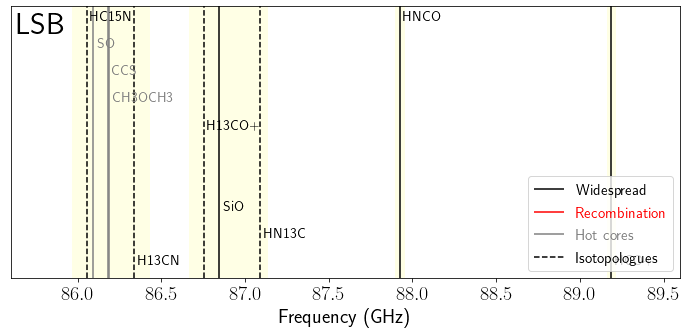

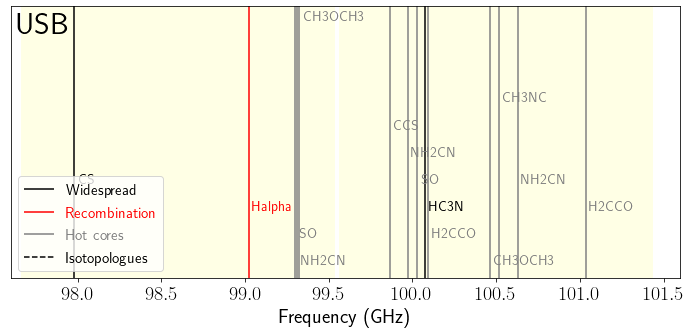

In [5]:
# Input the information about your chosen ALMA spectral setup    

LO = 93.6 # For plotting reference

BB = pylab.array([86.2,86.9,89.188526,87.925237,98.6,100.5])
BW = pylab.array([0.46875,0.46875,0.05859,0.05859,1.875,1.875])



##################
#Query Splatalogue

freqs, mols = splat(bbs=BB,bws=BW)


# Plot the LSB/USB
SPW_plot(LO=LO,bbs=BB,bws=BW,ms=mols,fs=freqs,ls=linestyles,pc=pcolors,lb=labels,atm=0)

